In [1]:
###: Loading H2O Library

In [2]:
import h2o

In [3]:
###: Get H2O Version

In [4]:
h2o.__version__

u'3.14.0.7'

In [5]:
###: Initalizing H2O cluster

In [6]:
h2o.init()

ERROR:h2o:Key init.version_check is not a valid config key


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /Users/avkashchauhan/anaconda3/envs/python27/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/x7/331tvwcd6p17jj9zdmhnkpyc0000gn/T/tmp_XjvDw
  JVM stdout: /var/folders/x7/331tvwcd6p17jj9zdmhnkpyc0000gn/T/tmp_XjvDw/h2o_avkashchauhan_started_from_python.out
  JVM stderr: /var/folders/x7/331tvwcd6p17jj9zdmhnkpyc0000gn/T/tmp_XjvDw/h2o_avkashchauhan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,1 month and 3 days
H2O cluster name:,H2O_from_python_avkashchauhan_f2o7dk
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [7]:
###: Importing both training and test dataset into H2O cluster memory

In [8]:
#train_df = h2o.import_file("/Users/avkashchauhan/examples/regression/house_price_train.csv")
#test_df = h2o.import_file("/Users/avkashchauhan/examples/regression/house_price_test.csv")

train_df = h2o.import_file("https://raw.githubusercontent.com/Avkash/mldl/master/data/house_price_train.csv")
test_df = h2o.import_file("https://raw.githubusercontent.com/Avkash/mldl/master/data/house_price_test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
###: Understanding Training dataset

In [10]:
train_df.describe()

Rows:407
Cols:14




,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
type,real,real,real,int,real,real,real,real,int,int,real,real,real,real
mins,0.00906,0.0,0.46,0.0,0.385,3.863,2.9,1.1296,1.0,188.0,12.6,0.32,1.73,5.0
mean,3.56736771499,10.5872235872,11.4092628993,0.0687960687961,0.556763882064,6.28658230958,69.3889434889,3.71767051597,9.83783783784,412.378378378,18.4474201474,354.403218673,12.792039312,22.6248157248
maxs,73.5341,100.0,27.74,1.0,0.871,8.725,100.0,10.7103,24.0,711.0,22.0,396.9,37.97,50.0
sigma,7.94798961655,22.2597824603,6.8144822924,0.253418548596,0.115557348898,0.690897322921,27.8179045475,2.01524090631,8.78440418525,170.44740987,2.16176742548,94.175205015,7.09869539936,9.18501930903
zeros,0,301,0,379,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
1,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4


In [11]:
###: Understanding Test dataset

In [12]:
test_df.describe()

Rows:99
Cols:14




,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
type,real,real,real,int,real,real,real,real,int,int,real,real,real,real
mins,0.00632,0.0,0.74,0.0,0.389,3.561,9.9,1.1781,1.0,187.0,12.6,6.68,2.88,5.6
mean,3.80327535354,14.5555555556,10.0165656566,0.0707070707071,0.54618989899,6.27662626263,65.2282828283,4.11312828283,8.36363636364,391.212121212,18.4888888889,366.00959596,12.0817171717,22.1545454545
maxs,88.9762,95.0,27.74,1.0,0.871,8.78,100.0,12.1265,24.0,711.0,22.0,396.9,34.41,50.0
sigma,10.9318629744,27.154498339,6.96902859181,0.257639411539,0.11739221152,0.752520981955,29.378799938,2.42831711324,8.3206830389,160.149373687,2.18869492793,78.0843033028,7.32150592857,9.28388193709
zeros,0,71,0,92,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
1,0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
2,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.9,18.72,15.2


In [13]:
###: Training and test dataset - columns and rows details

In [14]:
print(train_df.shape)
print(test_df.shape)

(407, 14)
(99, 14)


In [15]:
###: Training and Test Dataframes - columns names

In [16]:
print(train_df.col_names)
print(test_df.col_names)

[u'crim', u'zn', u'indus', u'chas', u'nox', u'rm', u'age', u'dis', u'rad', u'tax', u'ptratio', u'b', u'lstat', u'medv']
[u'crim', u'zn', u'indus', u'chas', u'nox', u'rm', u'age', u'dis', u'rad', u'tax', u'ptratio', u'b', u'lstat', u'medv']


In [17]:
###: Settings response or target variable for supervised machine learning

In [18]:
response = "medv"
features = train_df.col_names
print(features)

[u'crim', u'zn', u'indus', u'chas', u'nox', u'rm', u'age', u'dis', u'rad', u'tax', u'ptratio', u'b', u'lstat', u'medv']


In [19]:
###: Creating a list of all features we will use for machine learning

In [20]:
features.remove(response)
print(features)

[u'crim', u'zn', u'indus', u'chas', u'nox', u'rm', u'age', u'dis', u'rad', u'tax', u'ptratio', u'b', u'lstat']


In [21]:
###: Understanding response variable values as historgram in Training data

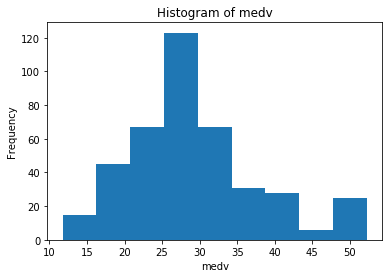

In [22]:
train_df['medv'].hist()

In [23]:
###: Importing H2O H2OGeneralizedLinearEstimator to build GLM Model

In [24]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [25]:
###:Building Gradient Boosting (GBM) -  Regression model with cross validation

In [26]:
glm_model_with_cv = H2OGeneralizedLinearEstimator(nfolds=5)
glm_model_with_cv.train(x = features, y = response, training_frame=train_df)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [27]:
###: Getting model performance

In [28]:
glm_model_with_cv.model_performance(valid=True,test_data=test_df).r2()

0.707592977773253

In [29]:
###:Building GLM -  Regression model with cross validation andkey GBM parameters configuration

In [30]:
glm_model_cv_config = H2OGeneralizedLinearEstimator(nfolds=5,
                                                    keep_cross_validation_predictions=True,
                                                    lambda_search = True,
                                                    alpha = 0.1,
                                                    seed=1)

In [31]:
###: Training GBM Model

In [32]:
glm_model_cv_config.train(x = features, y = response, 
                                            training_frame=train_df, 
                                           model_id = "glm_model_with_training_and_validtion_python")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [33]:
###: Getting GLM model performance on test data

In [34]:
glm_model_cv_config.model_performance(valid=True,test_data=test_df).r2()

0.7045783691552175

In [35]:
###: Importing H2O Grid Library

In [36]:
from h2o.grid import H2OGridSearch

In [37]:
###: Settings GLM grid parameters

In [38]:
glm_hyper_params = { 'alpha': [0.01,0.1,0.3,0.5,0.7,0.9], 
                     'lambda': [1e-1,1e-3,1e-5,1e-7,1e-9] }

In [39]:
###: Setting H2O Grid Search Criteria

In [40]:
grid_search_criteria = { 'strategy': "RandomDiscrete", 
                    'seed': 123,
                    'stopping_metric': "AUTO", 
                    'stopping_tolerance': 0.01,
                    'stopping_rounds': 5 }

In [41]:
###: Finalzing the H2I Grid searching settings

In [42]:
house_price_glm_grid = H2OGridSearch(model=H2OGeneralizedLinearEstimator(
                                                        seed=12345,
                                                        nfolds=5,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=glm_hyper_params,
                     search_criteria=grid_search_criteria,
                     grid_id="house_price_glm_grid")

In [43]:
###: Finally training H2O Grid with data 

In [44]:
house_price_glm_grid.train(x=features, y=response, training_frame=train_df)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [45]:
###: Finally getting total count of GLM models

In [46]:
len(house_price_glm_grid)

11

In [47]:
###: Defining a function to find the best model from the grid based on r2 or auc

In [48]:
def find_best_model_from_grid(h2o_grid, test_parameter):    
    model_list = []
    for grid_item in h2o_grid:
        if test_parameter is "r2":
            if not (grid_item.r2() == "NaN"):
                model_list.append(grid_item.r2())
            else:
                model_list.append(0.0)            
        elif test_parameter is "auc":
            if not (grid_item.auc() == "NaN"):
                model_list.append(grid_item.auc())
            else:
                model_list.append(0.0)            
    #print(model_list)        
    max_index = model_list.index(max(model_list))
    #print(max_index)
    best_model = h2o_grid[max_index]
    print("Model ID with best R2: " +  best_model.model_id)
    if test_parameter is "r2":
        print("Best R2: " +  str(best_model.r2()))
    elif test_parameter is "auc":
        print("Best AUC: " +  str(best_model.auc()))
    return best_model

In [49]:
###: Applying the function to get the best model from the grid

In [63]:
best_model = find_best_model_from_grid(house_price_glm_grid, "r2")

Model ID with best R2: house_price_glm_grid_model_6
Best R2: 0.744906222921


In [64]:
###: Getting the best model performance on test data

In [65]:
best_model.model_performance(valid=True,test_data=test_df).r2()

0.7087898024986435

In [66]:
###: Performing predictions with one of the above model

In [67]:
glm_predictions = best_model.predict(test_df)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [68]:
glm_predictions

predict
30.0449
25.6862
16.0524
13.9504
11.5023
14.3761
22.9156
22.6442
30.5
21.0966


In [69]:
###: Understanding/Validating predictions based on prediction results historgram

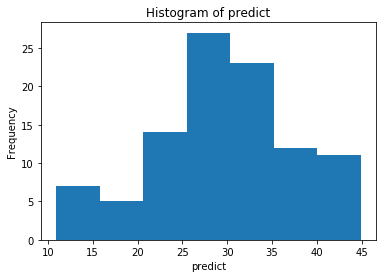

In [70]:
glm_predictions.hist()

In [71]:
###: Getting Scorring History

In [72]:
best_glm_model.scoring_history()

,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2017-11-24 11:28:14,0.000 sec,0,34252.019361,84.157296


In [73]:
###: Getting GBM model variable importance 

In [74]:
best_glm_model.varimp()

In [75]:
###: Getting GBM model variable importance PLOT

Variable importance does not apply to GLM. Will use std_coef_plot() instead.


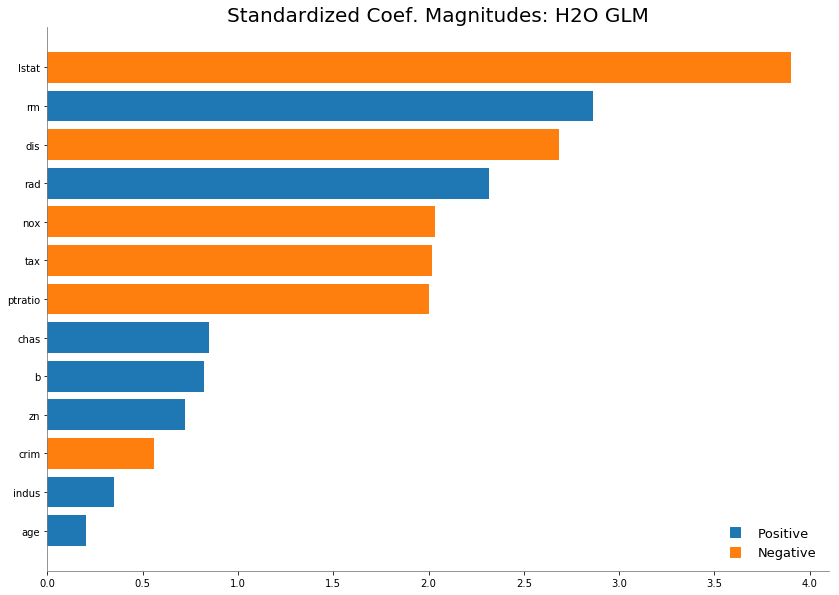

In [76]:
best_glm_model.varimp_plot()